# Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ..., PAY_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1 = задержка в один месяц, 2 = задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, ..., BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#reading the data
data = pd.read_csv('credit_card_default_analysis.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1. Размер кредитного лимита (LIMIT_BAL).

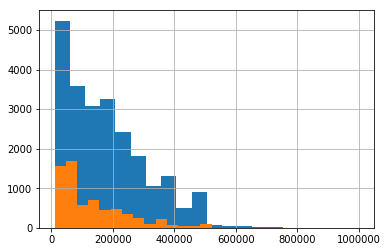

In [4]:
data[data['default']==0]['LIMIT_BAL'].hist(bins=20)
data[data['default']==1]['LIMIT_BAL'].hist(bins=20)

а)H0: медианные значения равны
H1: медианные значения отличаются

In [5]:
lim_bal_0 = data.LIMIT_BAL.loc[data.default == 0]
lim_bal_1 = data.LIMIT_BAL.loc[data.default == 1]

print('Median LIMIT_BAL for default = 0: %.0f' % lim_bal_0.median())
print('Median LIMIT_BAL for default = 1: %.0f' % lim_bal_1.median())

Median LIMIT_BAL for default = 0: 150000
Median LIMIT_BAL for default = 1: 90000


#### Бутстрэп

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
np.random.seed(0)

lim_bal_0_bs_med = list(map(np.median, get_bootstrap_samples(lim_bal_0.values, 100)))
lim_bal_1_bs_med = list(map(np.median, get_bootstrap_samples(lim_bal_1.values, 100)))

bnd_0 = stat_intervals(lim_bal_0_bs_med, 0.05)
bnd_1 = stat_intervals(lim_bal_1_bs_med, 0.05)

print('Conf. int. median LIMIT_BAL for default = 0: [%d, %d]' % (bnd_0[0], bnd_0[1]))
print('Conf. int. median LIMIT_BAL for default = 1: [%d, %d]' % (bnd_1[0], bnd_1[1]))

Conf. int. median LIMIT_BAL for default = 0: [150000, 150000]
Conf. int. median LIMIT_BAL for default = 1: [80000, 90000]


Заёмщики, которые не возвращают кредит, обычно берут меньшую сумму.

#### б) Проверка гипотезы о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.

H0: распределения выборок полностью равны
H1: распределения выборок отличаются на величину сдвига

In [8]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample1, sample2, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [9]:
print('p-value: %f' % permutation_test(lim_bal_0, lim_bal_1, max_permutations=1000))

p-value: 0.001000


P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05.

Результат является практически значимым, потому что разница в значениях медианы LIMIT_BAL значимо большая.

<b>

### 2. Пол (SEX).

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

SEX: пол клиента (1 = мужской, 2 = женский )

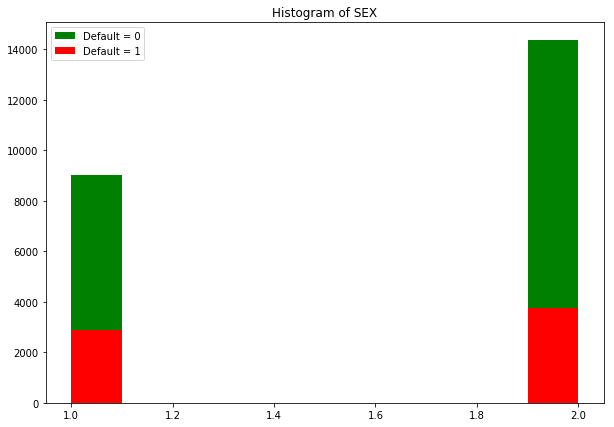

In [10]:
plt.figure(1, figsize=(10,7))
plt.title('Histogram of SEX')
plt.hist(data.SEX[data.default == 0], label='Default = 0', color='green')
plt.hist(data.SEX[data.default == 1], label='Default = 1', color='red')
plt.legend()

Женщины более склонны к невозврату кредита, чем мужчины.

#### Построим доверительные интервалы для доли вернувших, не вернувших и для их разности.

In [11]:
sex_0 = data.SEX[data.default == 0].values
sex_1 = data.SEX[data.default == 1].values

In [12]:
conf_int_0 = proportion_confint(np.where(sex_0 == 1)[0].shape[0], sex_0.shape[0])
conf_int_1 = proportion_confint(np.where(sex_1 == 1)[0].shape[0], sex_1.shape[0])

print('Conf. int. for prop. of men or default = 0: [%.4f, %.4f]' % conf_int_0)
print('Conf. int. for prop. of men or default = 1: [%.4f, %.4f]' % conf_int_1)

Conf. int. for prop. of men or default = 0: [0.3796, 0.3921]
Conf. int. for prop. of men or default = 1: [0.4210, 0.4449]


Интервалы не пересекаются, следовательно гендерный состав различается.

Построим доверительный интервал для разности двух долей независимых выборок.

In [13]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    
    return (left_boundary, right_boundary)

In [14]:
print('Conf. int. for difference: [%f, %f]' % proportions_confint_diff_ind(np.abs(sex_0-2), np.abs(sex_1-2)))

Conf. int. for difference: [-0.060548, -0.033635]


#### Используем статистический Z-критерий для доли для двух независимых выборок.

* H0: гендерный состав не отличается
* H1: гендерный состав отличается

In [15]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [16]:
def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [17]:
print('p-value: %.15f' % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(sex_0-2), np.abs(sex_1-2))))

p-value: 0.000000000004473


Гипотеза о равенстве гендерного распределния отвергается.

<b>

### 3. Образование (EDUCATION).

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных)

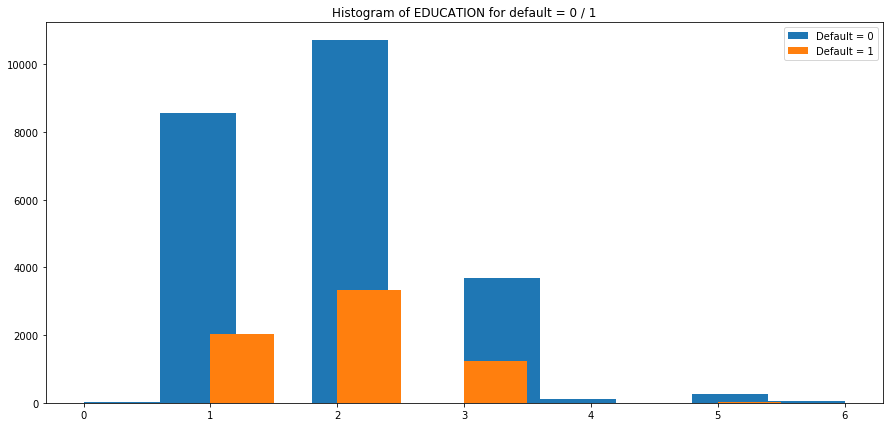

In [18]:
plt.figure(figsize=(15,7))
plt.title('Histogram of EDUCATION for default = 0 / 1')
plt.hist(data.EDUCATION[data.default == 0], label='Default = 0')
plt.hist(data.EDUCATION[data.default == 1], label='Default = 1')
plt.legend()

#### Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.

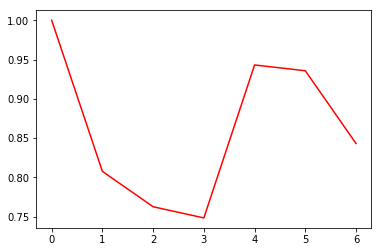

In [19]:
edu = data.EDUCATION
edu_0 = data.EDUCATION.loc[data.default == 0]
edu_1 = data.EDUCATION.loc[data.default == 1]

edu_prop = list()
for i, step in enumerate(np.unique(edu)):
    edu_prop.append(edu_0[edu_0 == step].shape[0] / 
                    (edu_0[edu_0 == step].shape[0] + edu_1[edu_1 == step].shape[0]))

plt.plot(np.unique(edu), edu_prop, 'r')

Распределние не является равномерным, следовательно, образование влияет на то, вернёт ли человек долг.
Наличие какого образования является наилучшим индикатором того, что человек отдаст долг - доктора, наоборт, не отдаст долг - бакалавры и выпускники школ

### 4. Семейное положение (MARRIAGE).

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

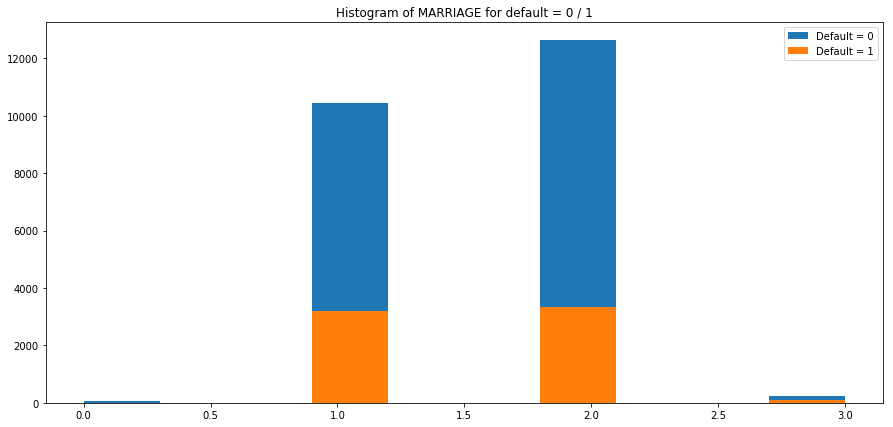

In [20]:
plt.figure(figsize=(15,7))
plt.title('Histogram of MARRIAGE for default = 0 / 1')
plt.hist(data.MARRIAGE[data.default == 0], label='Default = 0')
plt.hist(data.MARRIAGE[data.default == 1], label='Default = 1')
plt.legend()

In [21]:
mar_0 = data.MARRIAGE[data.default == 0]
mar_1 = data.MARRIAGE[data.default == 1]

data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Составим таблицу сопряжённости для признаков default и MARRIAGE.

In [22]:
table = np.empty( (len(data.MARRIAGE.value_counts()), 2) )
for i in range(len(data.MARRIAGE.value_counts())):
    table[i, 0] = len(mar_0[mar_0 == i])
    table[i, 1] = len(mar_1[mar_1 == i])
print (table)

[[4.9000e+01 5.0000e+00]
 [1.0453e+04 3.2060e+03]
 [1.2623e+04 3.3410e+03]
 [2.3900e+02 8.4000e+01]]


In [23]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [24]:
print('V Cramer stat: %.4f' % cramers_stat(table))

V Cramer stat: 0.0345


Нет разницы в том, с каким статусом полом приходит человек за кредитом.

### 5. Возраст (AGE).

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

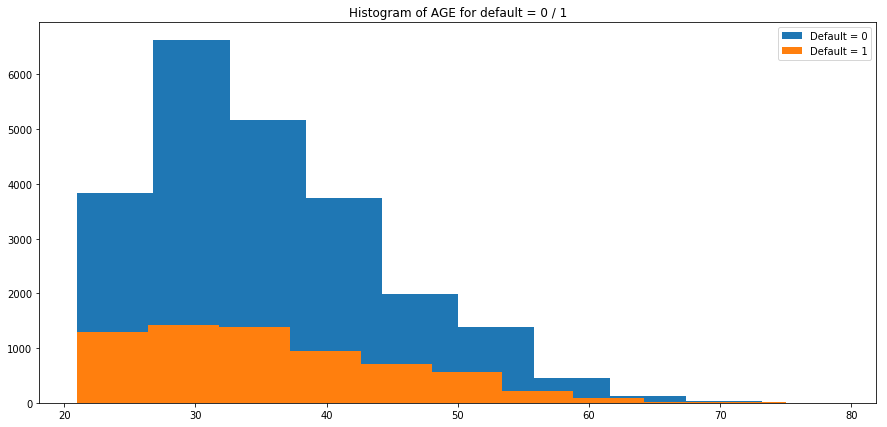

In [25]:
plt.figure(1, figsize=(15,7))
plt.title('Histogram of AGE for default = 0 / 1')
plt.hist(data.AGE[data.default == 0], label='Default = 0')
plt.hist(data.AGE[data.default == 1], label='Default = 1')
plt.legend()

#### Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.

* H0: медианные значения равны
* H1: медианные значения отличаются

In [26]:
age_0 = data.AGE[data.default == 0]
age_1 = data.AGE[data.default == 1]

print('for default = 0: %d' % age_0.median())
print('for default = 1: %d' % age_1.median())

for default = 0: 34
for default = 1: 34


#### Доверительный интервал для медианы на основе бутстрепа.

In [27]:
np.random.seed(0)

age_0_bs_med = list(map(np.median, get_bootstrap_samples(age_0.values, 100)))
age_1_bs_med = list(map(np.median, get_bootstrap_samples(age_1.values, 100)))

bnd_0 = stat_intervals(age_0_bs_med, 0.05)
bnd_1 = stat_intervals(age_1_bs_med, 0.05)

print('for default = 0: [%f, %f]' % (bnd_0[0], bnd_0[1]))
print('for default = 1: [%f, %f]' % (bnd_1[0], bnd_1[1]))

for default = 0: [34.000000, 34.000000]
for default = 1: [34.000000, 35.000000]


Интервальные оценки для медианы пересекаются.

#### Построим интервальную оценку для разности медиан.

In [28]:
print(np.median(age_0) - np.median(age_1))

0.0


In [29]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_0_bs_med, age_1_bs_med)))

In [30]:
stat_int = stat_intervals(delta_median_scores, 0.05)
print('95%% conf. int. for the difference between medians: [%f, %f]' % (stat_int[0], stat_int[1]))

95% conf. int. for the difference between medians: [0.000000, 1.000000]


Доверительный интервал содержит ноль, следовательно значения медиан не различаются.

#### С помощью одного из подходящих непараметрических критериев проверки равенства средних.

Перестановочный критерий для независимых выборок.

* H0: распределения выборок полностью равны
* H1: распределения выборок отличаются на величину сдвига

In [31]:
print('p-value: %f' % permutation_test(age_0, age_1, max_permutations=1000))

p-value: 0.014000


Нулевая гипотеза отвергается на уровне значимости 0.05.